# Load and prepare data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = './data/'

In [2]:
# Read the CSV file with spectral types
df_spectra = pd.read_csv(f'{path}combined_data_with_spectra_info.csv')
print("CSV columns:", df_spectra.columns.tolist())

print(df_spectra.tail())

CSV columns: ['targetid', 'survey', 'program', 'desi_target', 'mean_fiber_ra', 'mean_fiber_dec', 'z', 'zwarn', 'spectype', 'desiname', 'specid', 'redshift']
              targetid survey program          desi_target  mean_fiber_ra  \
487  39628023619653667   main    dark               917542     257.195433   
488  39627863674064234   main    dark  4611686018428305446      25.624824   
489  39627915117200049   main    dark               262148     217.878014   
490  39627700758912844   main    dark               917606      34.255517   
491  39627766823390528   main    dark  4611686018427650052      12.844649   

     mean_fiber_dec         z  zwarn spectype                desiname  \
487        9.707699  1.633331      0      QSO  DESI J257.1954+09.7077   
488        3.317234  0.799710      0      QSO  DESI J025.6248+03.3172   
489        5.151131  1.395416      4   GALAXY  DESI J217.8779+05.1511   
490       -3.549613  0.073466      4   GALAXY  DESI J034.2555-03.5496   
491       -0.78

In [3]:
# To load later:
def load_flux_dict_from_npz(filepath):
    """Load flux dictionary from NumPy .npz file"""
    data = np.load(filepath, allow_pickle=True)
    targetids = data['targetids']
    flux_arrays = data['flux_arrays']
    
    # Reconstruct dictionary
    flux_dict = {tid: flux for tid, flux in zip(targetids, flux_arrays)}
    print(f"Loaded {len(flux_dict)} spectra from {filepath}")
    return flux_dict


flux_dict = load_flux_dict_from_npz(f'{path}/primary_spectra_flux.npz')

Loaded 492 spectra from ./data//primary_spectra_flux.npz


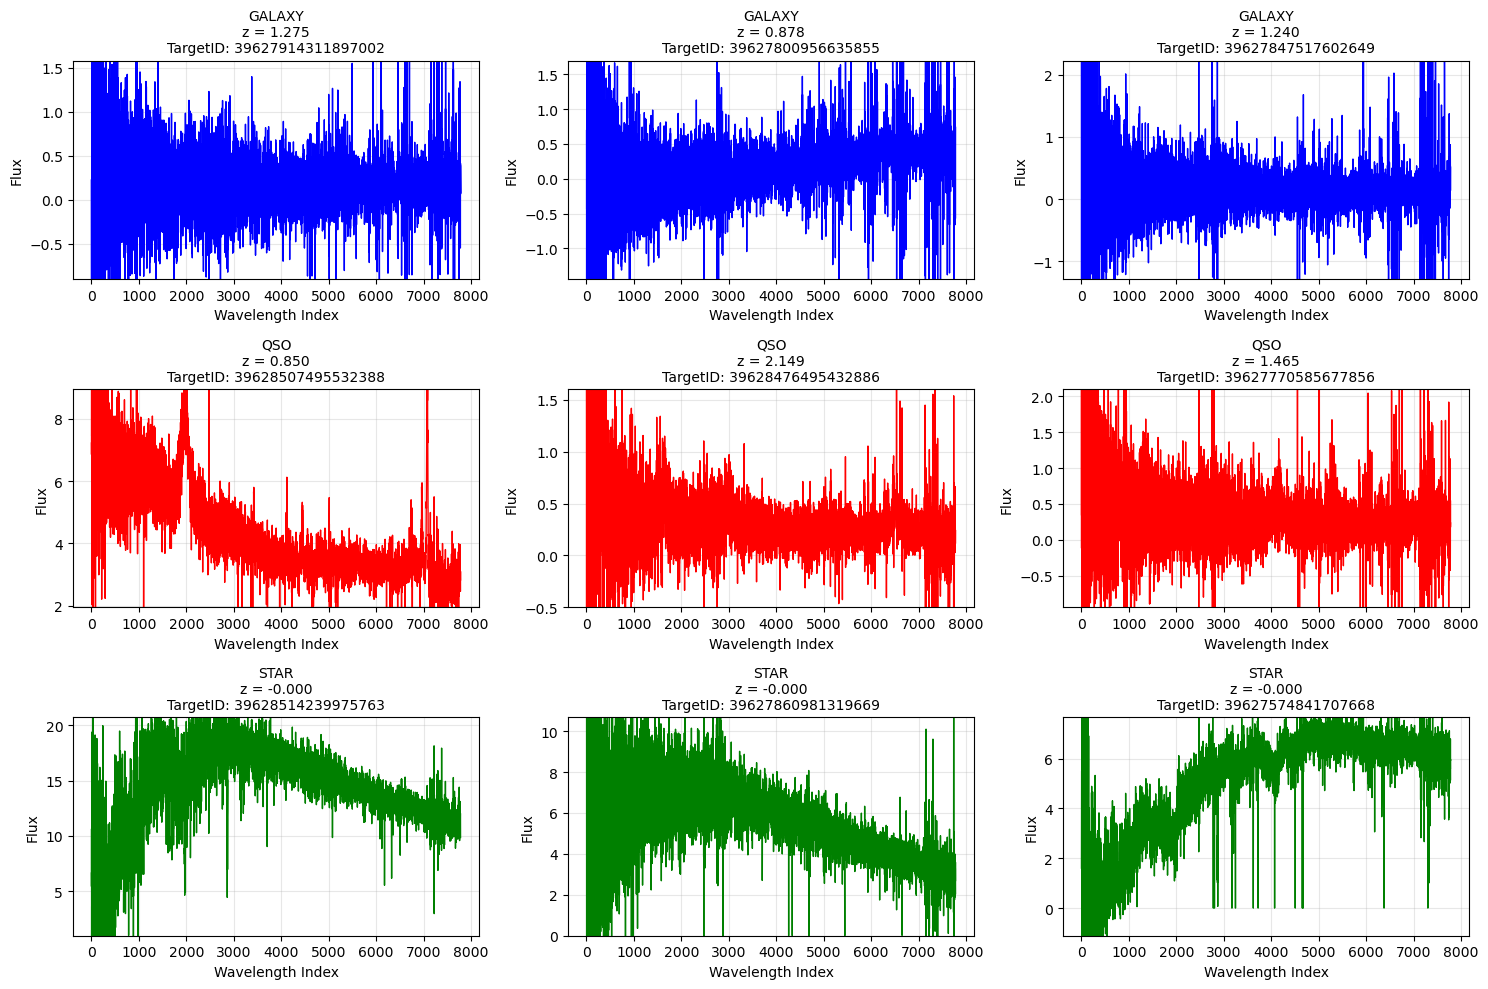

In [4]:
# Plot some examples
def plot_spectra_examples_from_dict(flux_dict, df_spectra, n_examples=3, figsize=(15, 10)):
    """
    Plot example spectra directly from flux_dict and df_spectra
    """
    # Set up the plot
    fig, axes = plt.subplots(3, n_examples, figsize=figsize)
    class_names = ['GALAXY', 'QSO', 'STAR']
    colors = ['blue', 'red', 'green']
    
    for class_idx, class_name in enumerate(class_names):
        # Filter DataFrame for this class
        class_df = df_spectra[df_spectra['spectype'] == class_name]
        
        # Filter only rows that have flux data
        class_df = class_df[class_df['targetid'].isin(flux_dict.keys())]
        
        # Randomly select examples
        if len(class_df) > 0:
            selected_rows = class_df.sample(n=min(n_examples, len(class_df)), random_state=42)
        else:
            print(f"No examples found for {class_name}")
            continue
            
        for example_idx, (idx, row) in enumerate(selected_rows.iterrows()):
            ax = axes[class_idx, example_idx]
            
            # Get flux data from dictionary
            targetid = row['targetid']
            flux = flux_dict[targetid]
            redshift = row['redshift']
            spectype = row['spectype']
            
            # Create wavelength array
            wavelength = np.arange(len(flux))
            
            # Plot the spectrum
            ax.plot(wavelength, flux, color=colors[class_idx], linewidth=1)
            ax.set_title(f'{spectype}\nz = {redshift:.3f}\nTargetID: {targetid}', fontsize=10)
            ax.set_xlabel('Wavelength Index')
            ax.set_ylabel('Flux')
            ax.grid(True, alpha=0.3)
            
            # Set y-axis limits based on data range (excluding outliers)
            y_min = np.percentile(flux, 1)
            y_max = np.percentile(flux, 99)
            ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_spectra_examples_from_dict(flux_dict, df_spectra, n_examples=3)

# Classification

In [5]:
np.unique(df_spectra['spectype'])

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

Class Distribution:
GALAXY: 328 objects
QSO: 57 objects
STAR: 107 objects


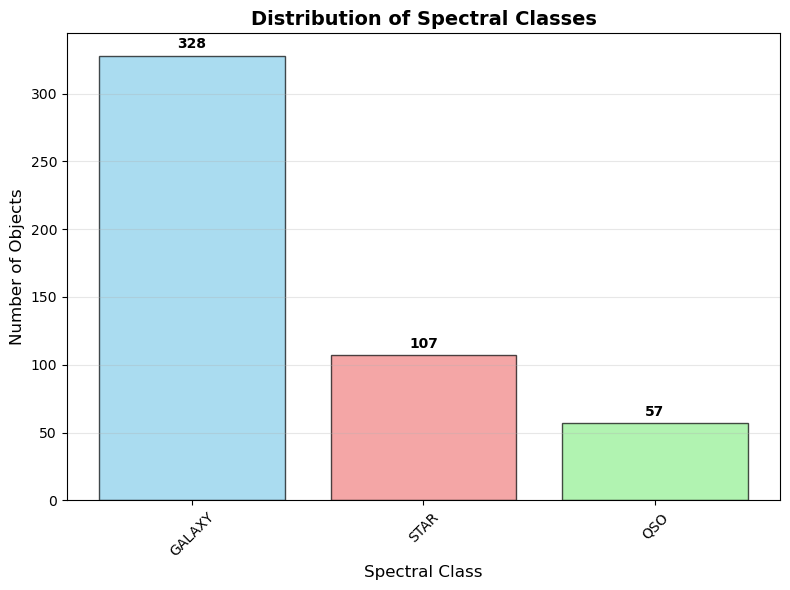

In [6]:
# Get class distribution
unique_classes = np.unique(df_spectra['spectype'])
class_counts = df_spectra['spectype'].value_counts()

print("Class Distribution:")
for class_name in unique_classes:
    count = class_counts[class_name]
    print(f"{class_name}: {count} objects")

# Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, 
               color=['skyblue', 'lightcoral', 'lightgreen'],
               edgecolor='black', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(class_counts.values)*0.01,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.title('Distribution of Spectral Classes', fontsize=14, fontweight='bold')
plt.xlabel('Spectral Class', fontsize=12)
plt.ylabel('Number of Objects', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
def prepare_classification_data(flux_dict, df_spectra):
    """
    Prepare X (flux arrays) and y (spectype labels) for classification
    """
    
    # Step 1: Match targetids between flux_dict and DataFrame
    matched_data = []
    
    for index, row in df_spectra.iterrows():
        targetid = row['targetid']
        
        # Check if targetid exists in both flux_dict and has valid spectype
        if (targetid in flux_dict and 
            pd.notna(row['spectype']) and 
            row['spectype'] in ['GALAXY', 'QSO', 'STAR']):
            
            matched_data.append({
                'targetid': targetid,
                'flux': flux_dict[targetid],
                'spectype': row['spectype']
            })
    
    # Create matched DataFrame
    matched_df = pd.DataFrame(matched_data)
    
    if len(matched_df) == 0:
        raise ValueError("No matching data found between flux_dict and DataFrame")
    
    print(f"Matched {len(matched_df)} records for classification")
    print(f"Spectype distribution:\n{matched_df['spectype'].value_counts()}")
    
    # Step 2: Prepare X (flux arrays)
    X = np.array([flux for flux in matched_df['flux']])
    print(f"X shape: {X.shape}")
    
    # Step 3: Prepare y (spectype labels)
    # Map spectype to numerical labels
    spectype_mapping = {'GALAXY': 0, 'QSO': 1, 'STAR': 2}
    y = matched_df['spectype'].map(spectype_mapping).values
    
    print(f"y shape: {y.shape}")
    print(f"Class distribution: GALAXY={np.sum(y==0)}, QSO={np.sum(y==1)}, STAR={np.sum(y==2)}")
    
    return X, y, matched_df

In [8]:
X, y, matched_df = prepare_classification_data(flux_dict, df_spectra)

Matched 492 records for classification
Spectype distribution:
spectype
GALAXY    328
STAR      107
QSO        57
Name: count, dtype: int64
X shape: (492, 7781)
y shape: (492,)
Class distribution: GALAXY=328, QSO=57, STAR=107


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_ml_data_classification(flux_dict, df_spectra, test_size=0.3, random_state=42):
    """
    Prepare data for machine learning with train/test split
    """
    
    # Get matched data
    X, y, matched_df = prepare_classification_data(flux_dict, df_spectra)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")
    
    # Optionally normalize the flux data
    # Reshape for scaling (flatten each spectrum, scale, then reshape back)
    original_shape = X_train.shape[1:]
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    # Reshape back to original format
    X_train = X_train_scaled.reshape(X_train.shape[0], *original_shape)
    X_test = X_test_scaled.reshape(X_test.shape[0], *original_shape)
    
    return X_train, X_test, y_train, y_test, matched_df, scaler

X_train, X_test, y_train, y_test, matched_df, scaler = prepare_ml_data_classification(flux_dict, df_spectra)

Matched 492 records for classification
Spectype distribution:
spectype
GALAXY    328
STAR      107
QSO        57
Name: count, dtype: int64
X shape: (492, 7781)
y shape: (492,)
Class distribution: GALAXY=328, QSO=57, STAR=107
Training set: (344, 7781), (344,)
Test set: (148, 7781), (148,)


In [10]:
# Scale the data (important for MLP and distance-based methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared and scaled!")

Data prepared and scaled!


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'MLP Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50, 30),
                                      random_state=42, max_iter=1000)
}

# Dictionary to store results
results = {}

# Train each model and make predictions
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for MLP, original for tree-based methods
    if 'MLP' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'model': model, 'predictions': y_pred, 'f1_score': f1}

    print(f"{name} F1 Score: {f1:.4f}")


Training Decision Tree...
Decision Tree F1 Score: 0.7712

Training Random Forest...
Random Forest F1 Score: 0.8347

Training Extra Trees...
Extra Trees F1 Score: 0.8455

Training MLP Neural Network...
MLP Neural Network F1 Score: 0.8116


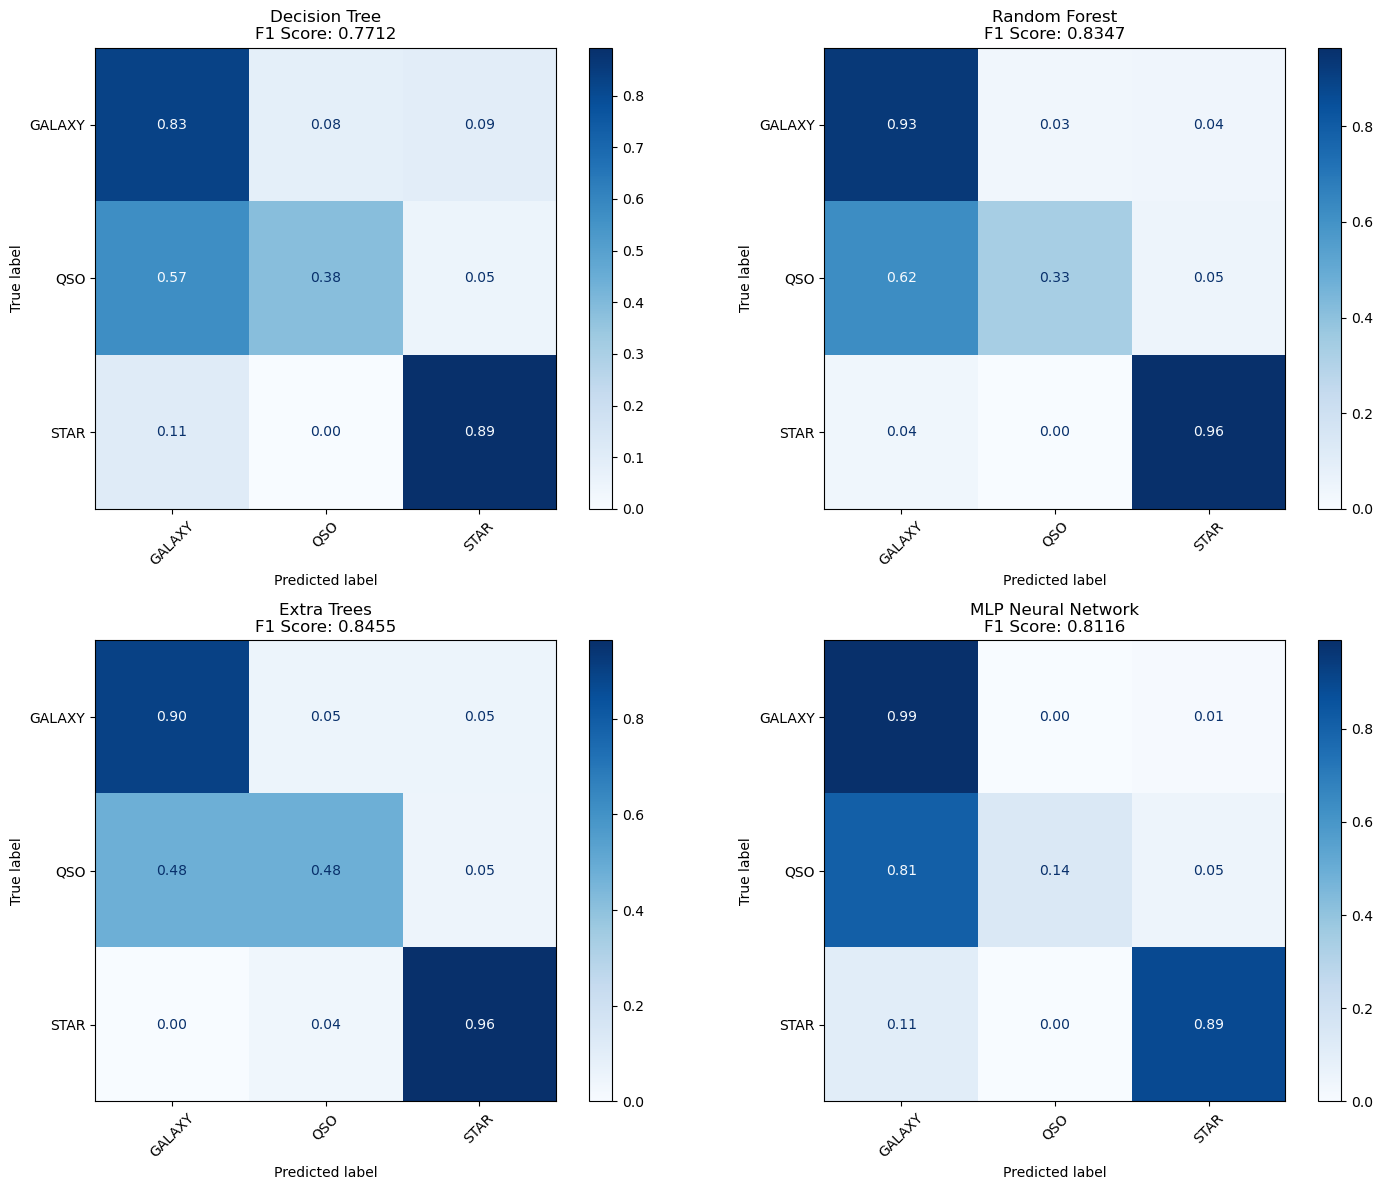


Model Comparison Summary
Decision Tree       : F1 Score = 0.7712
Random Forest       : F1 Score = 0.8347
Extra Trees         : F1 Score = 0.8455
MLP Neural Network  : F1 Score = 0.8116


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Plot confusion matrices for each model
for idx, (name, result) in enumerate(results.items()):
    # Calculate normalized confusion matrix
    cm = confusion_matrix(y_test, result['predictions'], normalize='true')  # Normalize by true labels
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['GALAXY', 'QSO', 'STAR'])  # Use class names for better readability
    disp.plot(ax=axes[idx], cmap='Blues', values_format='.2f')  # Format values to 2 decimal places
    axes[idx].set_title(f'{name}\nF1 Score: {result["f1_score"]:.4f}')

    # Improve readability
    plt.setp(axes[idx].get_xticklabels(), rotation=45)
    plt.setp(axes[idx].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print summary of results
print("\n" + "="*50)
print("Model Comparison Summary")
print("="*50)
for name, result in results.items():
    print(f"{name:<20}: F1 Score = {result['f1_score']:.4f}")

# Workshop Activity: Redshift Prediction from Spectra

In [13]:
def prepare_regression_data(flux_dict, df_spectra):
    """
    Prepare X (flux arrays) and y (redshift) for regression
    """
    
    # Step 1: Match targetids between flux_dict and DataFrame
    matched_data = []
    
    for index, row in df_spectra.iterrows():
        targetid = row['targetid']
        
        # Check if targetid exists in flux_dict and has valid redshift
        if (targetid in flux_dict and pd.notna(row['redshift'])):
            
            matched_data.append({
                'targetid': targetid,
                'flux': flux_dict[targetid],
                'redshift': row['redshift'],
                'spectype': row['spectype']
            })
    
    # Create matched DataFrame
    matched_df = pd.DataFrame(matched_data)
    
    if len(matched_df) == 0:
        raise ValueError("No matching data found between flux_dict and DataFrame")
    
    print(f"Matched {len(matched_df)} records for regression")
    print(f"Redshift range: {matched_df['redshift'].min():.3f} to {matched_df['redshift'].max():.3f}")
    print(f"Mean redshift: {matched_df['redshift'].mean():.3f}")
    
    # Step 2: Prepare X (flux arrays)
    X = np.array([flux for flux in matched_df['flux']])
    print(f"X shape: {X.shape}")
    
    # Step 3: Prepare y (redshift values)
    y = matched_df['redshift'].values
    print(f"y shape: {y.shape}")
    return X, y, matched_df

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_ml_data_regression(flux_dict, df_spectra, test_size=0.3, random_state=42):
    """
    Prepare data for machine learning with train/test split
    """
    
    # Get matched data
    X, y, matched_df = prepare_regression_data(flux_dict, df_spectra)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")
    
    # Optionally normalize the flux data
    # Reshape for scaling (flatten each spectrum, scale, then reshape back)
    original_shape = X_train.shape[1:]
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    # Reshape back to original format
    X_train = X_train_scaled.reshape(X_train.shape[0], *original_shape)
    X_test = X_test_scaled.reshape(X_test.shape[0], *original_shape)
    
    return X_train, X_test, y_train, y_test, matched_df, scaler

X_train, X_test, y_train, y_test, matched_df, scaler = prepare_ml_data_regression(flux_dict, df_spectra)

Matched 492 records for regression
Redshift range: -0.001 to 2.939
Mean redshift: 0.654
X shape: (492, 7781)
y shape: (492,)
Training set: (344, 7781), (344,)
Test set: (148, 7781), (148,)


In [15]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize regression models
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'MLP Neural Network': MLPRegressor(hidden_layer_sizes=(120, 70, 20),
                                     random_state=42, max_iter=1000)
}

# Dictionary to store results
results = {}

# Train each model and make predictions
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for MLP, original for tree-based methods
    if 'MLP' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {
        'model': model, 
        'predictions': y_pred, 
        'mse': mse,
        'r2': r2,
        'mae': mae
    }

    print(f"{name} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")


Training Decision Tree...
Decision Tree Metrics:
  MSE: 0.3221
  R²: 0.2045
  MAE: 0.3452

Training Random Forest...
Random Forest Metrics:
  MSE: 0.2250
  R²: 0.4442
  MAE: 0.2878

Training Extra Trees...
Extra Trees Metrics:
  MSE: 0.2074
  R²: 0.4877
  MAE: 0.2780

Training MLP Neural Network...
MLP Neural Network Metrics:
  MSE: 0.2943
  R²: 0.2732
  MAE: 0.4265


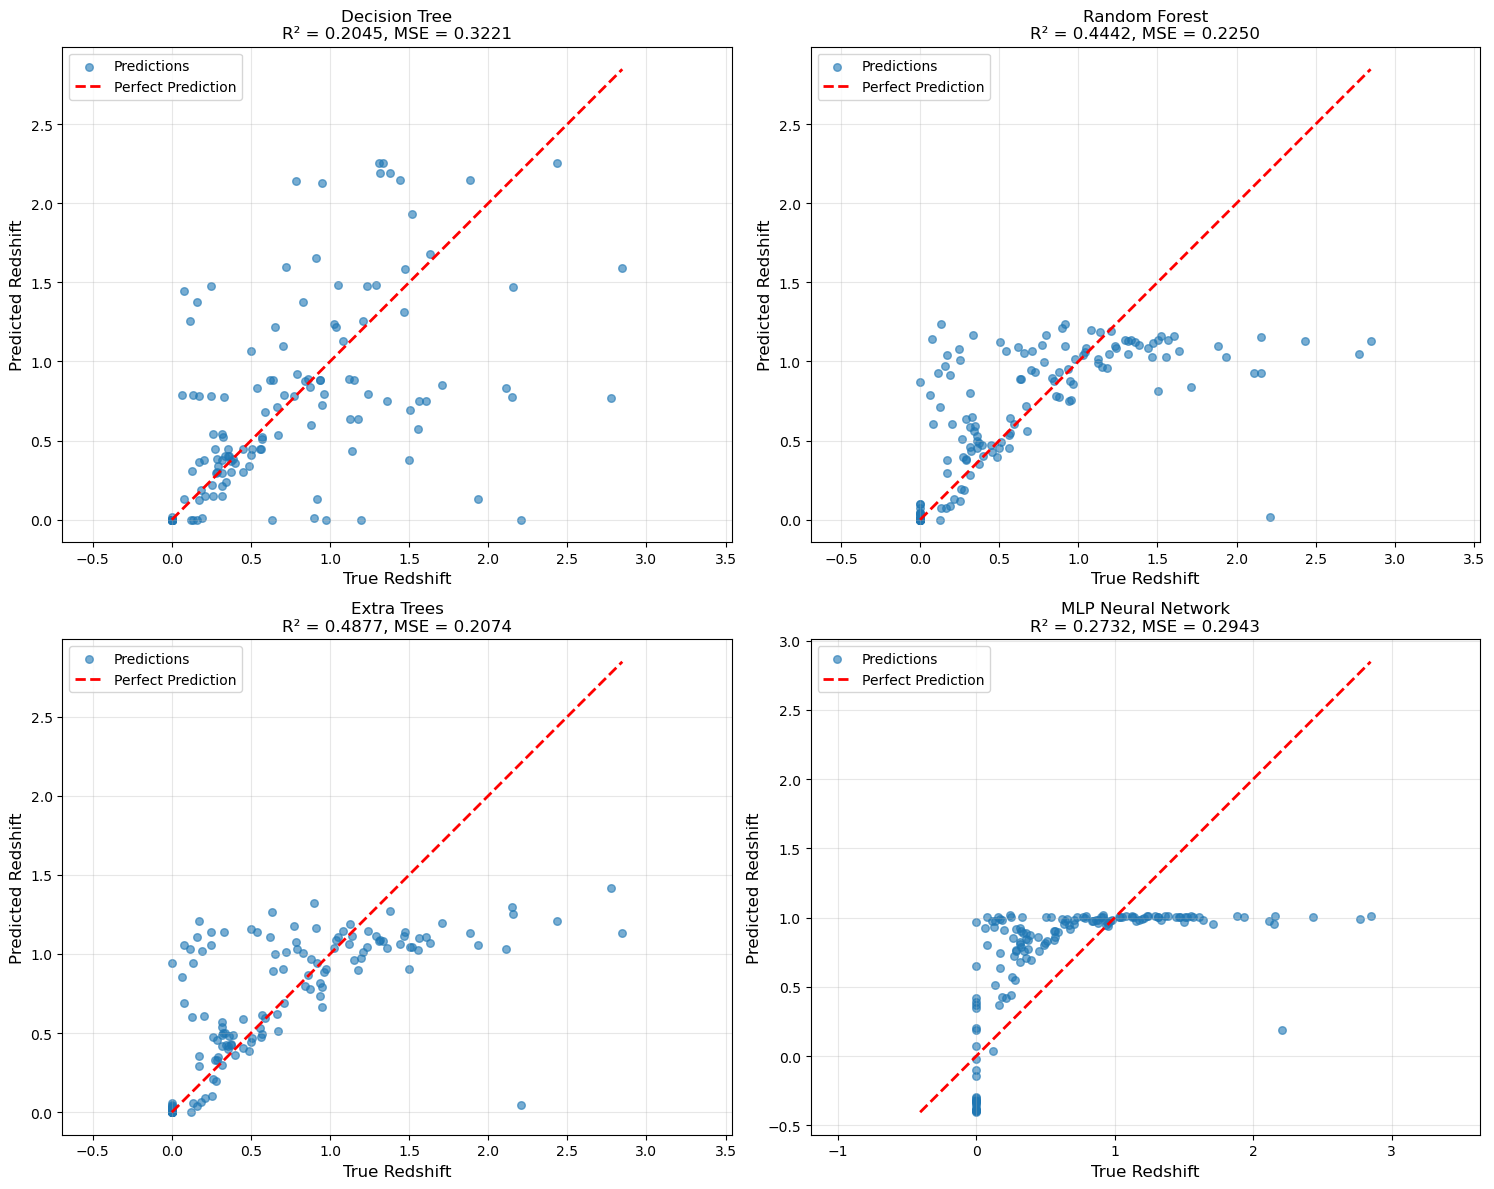


REGRESSION MODEL COMPARISON SUMMARY
Decision Tree       : R² = 0.2045, MSE = 0.3221, MAE = 0.3452
Random Forest       : R² = 0.4442, MSE = 0.2250, MAE = 0.2878
Extra Trees         : R² = 0.4877, MSE = 0.2074, MAE = 0.2780
MLP Neural Network  : R² = 0.2732, MSE = 0.2943, MAE = 0.4265


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Create a comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Plot diagonal plots for each regression model
for idx, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    
    # Scatter plot of predicted vs actual
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=30, label='Predictions')
    
    # Add perfect prediction line (diagonal)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('True Redshift', fontsize=12)
    axes[idx].set_ylabel('Predicted Redshift', fontsize=12)
    axes[idx].set_title(f'{name}\nR² = {result["r2"]:.4f}, MSE = {result["mse"]:.4f}', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()

# Print summary of results
print("\n" + "="*60)
print("REGRESSION MODEL COMPARISON SUMMARY")
print("="*60)
for name, result in results.items():
    print(f"{name:<20}: R² = {result['r2']:.4f}, MSE = {result['mse']:.4f}, MAE = {result['mae']:.4f}")